## 0. Importing Modules

In [1]:
##### some basic modules
import os
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

##### Image-related modules
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from sklearn.model_selection import train_test_split
import cv2 

##### keras module
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [3]:
##### Import custom function

# from alpha_model import model
from data_preprocessing import data_preprocessing
from visualization import visualize_validation_image
from fusion_model import fusion

## 1. Uploading and Preprocessing Dataset

##### Uploading

In [5]:
size_row = 128
size_col = 128

dir_name = '..' # name of directory where image data is located

In [6]:
train_image, test_image = data_preprocessing(dir_name, size_row, size_col)

1/173
2/173
3/173
4/173
5/173
6/173
7/173
8/173
9/173
10/173
11/173
12/173
13/173
14/173
15/173
16/173
17/173
18/173
19/173
20/173
21/173
22/173
23/173
24/173
25/173
26/173
27/173
28/173
29/173
30/173
31/173
32/173
33/173
34/173
35/173
36/173
37/173
38/173
39/173
40/173
41/173
42/173
43/173
44/173
45/173
46/173
47/173
48/173
49/173
50/173
51/173
52/173
53/173
54/173
55/173
56/173
57/173
58/173
59/173
60/173
61/173
62/173
63/173
64/173
65/173
66/173
67/173
68/173
69/173
70/173
71/173
72/173
73/173
74/173
75/173
76/173
77/173
78/173
79/173
80/173
81/173
82/173
83/173
84/173
85/173
86/173
87/173
88/173
89/173
90/173
91/173
92/173
93/173
94/173
95/173
96/173
97/173
98/173
99/173
100/173
101/173
102/173
103/173
104/173
105/173
106/173
107/173
108/173
109/173
110/173
111/173
112/173
113/173
114/173
115/173
116/173
117/173
118/173
119/173
120/173
121/173
122/173
123/173
124/173
125/173
126/173
127/173
128/173
129/173
130/173
131/173
132/173
133/173
134/173
135/173
136/173
137/173
138/173
139/

In [7]:
train_feature = train_image.reshape(train_image.shape[0], size_row, size_col, 3) 
test_feature = test_image.reshape(test_image.shape[0], size_row, size_col, 3)

x_feature = np.concatenate([train_feature, test_feature])

## 2. Defining and Fitting the Model

##### Define the model

In [8]:
classes = 173 # 173 represents the total number of characters I used in training set
input_shape = (size_row, size_col, 1)
channel_last = 3

fusion = fusion(input_shape = input_shape, channel_last = channel_last, classes = classes)


In [9]:
resnet = fusion.resnet() # define classifier

folder = "hdf5/resnet/" # name of directory where derived parameters for the classifier is saved
filename = "optimal.hdf5" # name of optimal classifier parameter saved

#Load weights
resnet.load_weights(folder+filename)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
model = fusion.model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 4)    40          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 8)    296         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 16)   1168        conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

##### Define the Generator

In [11]:
datagen = ImageDataGenerator()

def input_generator(batch_size):
        
    for batch_feature in datagen.flow(x_feature, batch_size = batch_size):        
                
        image_feature = []
        embed_feature = []
        image_label = []
        
        if len(batch_feature) == batch_size:
            
            for i in range(batch_size):
        
                image_gray3 = np.concatenate([rgb2gray(batch_feature[i,:,:,:]).reshape(size_row, size_col, 1)]*3, axis = 2)
                image_lab3 = rgb2lab(image_gray3)
                image_feature.append((image_lab3[:,:,0]/128).reshape(size_row, size_col, 1)) # scaling from -1 to 1

                # create label first with rgb2lab image
                image_lab = rgb2lab(batch_feature[i,:,:,:].reshape(size_row, size_col, 3))
                image_label.append((image_lab[:,:,1:]/128).reshape(size_row, size_col, 2)) # scaling from -1 to 1

                # create embedding list
                embed_predict = resnet.predict((image_lab3[:,:,0]/128).reshape(1, size_row, size_col, 1))
                embed_feature.append(embed_predict.reshape(classes))
                
                
        else: # at the end of the batch
            
            
            feature_size = len(x_feature)
            batch_size_end = feature_size - (feature_size//batch_size)*batch_size
            

            for i in range(batch_size_end):
        
                image_gray3 = np.concatenate([rgb2gray(image_gray[i,:,:,:].reshape(size_row, size_col, 1))]*3, axis = 2)
                image_lab3 = rgb2lab(image_gray3)
                image_feature.append((image_lab3[:,:,0]/128).reshape(size_row, size_col, 1)) # scaling from -1 to 1

                # create label first with rgb2lab image
                image_lab = rgb2lab(batch_feature[i,:,:,:].reshape(size_row, size_col, 3))
                image_label.append((image_lab[:,:,1:]/128).reshape(size_row, size_col, 2)) # scaling from -1 to 1
    
                # create embedding feature
                embed_predict = resnet.predict((image_lab3[:,:,0]/128).reshape(1, size_row, size_col, 1))
                embed_feature.append(embed_predict.reshape(classes))
    
    
        yield ([np.array(image_feature), np.array(embed_feature)], np.array(image_label))


##### Fitting

In [12]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
image_valid = cv2.resize(image_valid, (size_row, size_col))

img_gray = rgb2gray(image_valid).reshape(128, 128, 1)
img_gray3 = np.concatenate([img_gray]*3, axis = 2) # concatenating three gray images so that it can have 3 channels
img_lab3 = rgb2lab(img_gray3) # convert concatenated image to lab

valid_input = img_lab3[:,:,0].reshape(1, size_row, size_col, 1)/128

#### Note: need to run 'predict' once in order to avoid 'Tensor is not an element of this graph' error

In [13]:
resnet.predict(valid_input)

array([[4.28771782e-05, 1.70234049e-08, 1.08668994e-08, 1.34755638e-08,
        3.93202519e-08, 1.41384064e-07, 3.52775911e-04, 5.65954178e-06,
        3.77580873e-05, 3.87819512e-07, 3.41209397e-06, 2.64081905e-06,
        5.13957712e-05, 1.34258706e-04, 5.74039316e-10, 4.46964421e-09,
        2.25209387e-05, 1.54507761e-05, 6.56915009e-11, 2.38457687e-05,
        5.09093843e-06, 7.78173329e-04, 3.89107390e-06, 2.92615674e-04,
        4.96995142e-07, 8.56559041e-07, 1.17497088e-03, 7.65227105e-06,
        7.52994902e-06, 5.62514913e-07, 6.09883165e-04, 2.63780748e-07,
        1.94775290e-04, 1.89892518e-07, 1.07358119e-06, 5.28309560e-14,
        4.71923442e-04, 2.72426201e-04, 2.89236650e-05, 4.38209099e-05,
        4.75009438e-06, 4.74106746e-05, 2.35803554e-06, 2.76173203e-04,
        1.30518640e-06, 4.66901074e-05, 2.19833964e-06, 2.48350524e-11,
        2.91307674e-06, 7.07403558e-08, 1.35259972e-06, 4.96027965e-08,
        4.20901802e-09, 2.03512218e-06, 1.15001676e-05, 8.967227

##### Fitting

In [14]:
model_loss = []
img_colorized = []

for i in range(3000):

    model_hist = model.fit_generator(input_generator(batch_size = 64), 
                                     epochs=1,
                                     steps_per_epoch = 1,
                                     verbose = 0)
    
    model_loss.append(model_hist.history['loss'])
    
    if i % 150 == 0:
        
        print(i, model_hist.history['loss'])
                
        pred = model.predict([valid_input, resnet.predict(valid_input)])    
        pred = pred.reshape(size_row, size_col, 2)
        
        cur_pred = np.zeros((size_row, size_col, 3))             
        # Output colorizations
        cur_pred[:,:,0] = valid_input.reshape(size_row, size_col) * 128 # lab class
        cur_pred[:,:,1:] = pred*128 # lab predicted
        
#         plt.imshow(lab2rgb(cur_pred))
#         plt.axis('off')
#         plt.show()
        
        img_colorized.append(lab2rgb(cur_pred))


0 [0.023916814476251602]
150 [0.01768699660897255]
300 [0.0180572047829628]
450 [0.017535854130983353]
600 [0.016349349170923233]
750 [0.01671641133725643]
900 [0.01631111465394497]
1050 [0.016187116503715515]
1200 [0.015105368569493294]
1350 [0.016837874427437782]
1500 [0.016747865825891495]
1650 [0.016573701053857803]
1800 [0.015239045023918152]
1950 [0.015379553660750389]
2100 [0.012443918734788895]
2250 [0.016655780375003815]
2400 [0.015487432479858398]
2550 [0.016126330941915512]
2700 [0.015947163105010986]
2850 [0.01918245665729046]


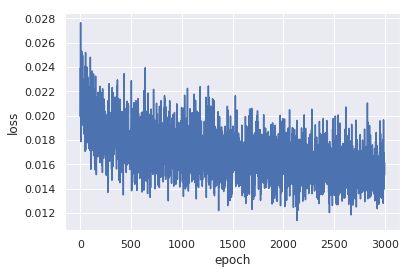

In [15]:
##### Plot loss function

plt.plot(model_loss)
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

##### Visualization

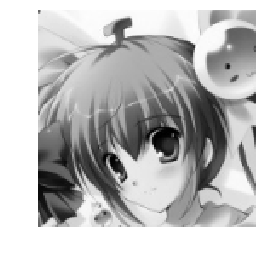

In [16]:
input_val = img_gray.copy()
plt.imshow(input_val.reshape(size_row, size_col), cmap = 'gray')
plt.axis('off')
plt.show()

In [17]:
grid_row = 4
grid_col = 5

In [18]:
g_row = []
i = 0

for r in range(grid_row):
    
    g_column = []
    
    for c in range(grid_col):
        g_column.append(img_colorized[i])
        i += 1
        
    g_column = np.concatenate(g_column, axis = 1)
    g_row.append(g_column)

g_row = np.concatenate(g_row)

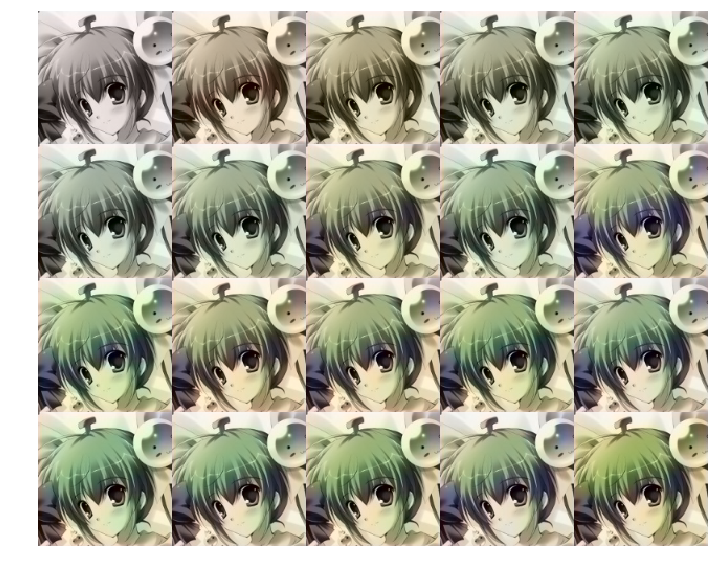

In [19]:
plt.figure(figsize = (12,12))
plt.axis('off')
plt.imshow(g_row)

##### Test with different image (same character)

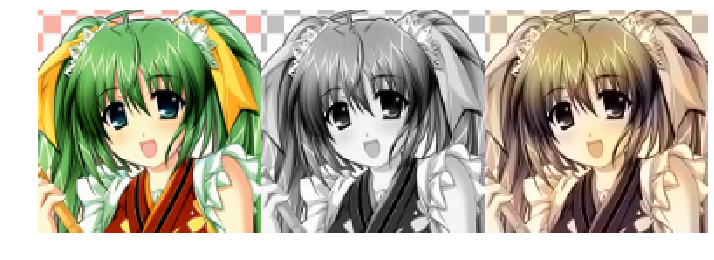

In [23]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
visualize_validation_image(image_valid, model, classifier = resnet, image_size = (size_row, size_col))

##### Test with Different Character

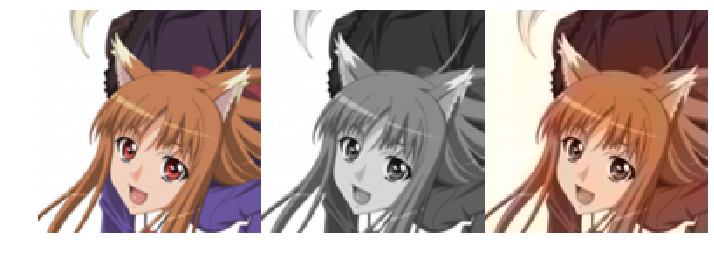

In [24]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
visualize_validation_image(image_valid, model, classifier = resnet, image_size = (size_row, size_col))